# Iris/dask dataset processing investigation

## Introduction

This demos using dask functionality beyond the `array` module to help with Iris processing. Specifically, in this notebook we will demo alternative approaches for loading numerous and/or large datasets into Iris.

Three approaches will be compared:

* The standard Iris load
* ~~Wrapping Iris load calls in a **dask bag** generated from a sequence (this is slow so will not be investigated further)~~
* Wrapping Iris load calls in a **dask bag** generated from a **delayed** call

These options will be compared with two simple metrics:

- Ease of use
- Runtime

## Setup

Below are the functions used to load the dataset. There is one function for each of the standard Iris load and the bag generated from a sequence. The bag generated from a delayed call requires two functions; one which is delayed, one to call the delayed function.

### Imports

In [2]:
import glob
import os
import time

import dask
import dask.array as da
import dask.bag as db
import dask.delayed as delayed
import iris

### Dask processing options

Define options on how dask is to process computation of graphs. Choose one of these!

In [8]:
from distributed import Client

host_subnet = 57
s = '10.154.1.{}:8776'.format(host_subnet)

client = Client(s)

In [10]:
print dask.context._globals

defaultdict(<function <lambda> at 0x7f63b418f230>, {'callbacks': set([]), 'shuffle': 'tasks', 'get': <bound method Client.get of <Client: scheduler="10.154.1.57:8776" processes=480 cores=480>>})


### Loader function

In [13]:
def preprocess_cube(cube, fld, fn):
    """Remove FRT coord, take first 24hrs, ensure grid_lat shape."""
    cube.remove_coord('forecast_reference_time')
    if cube.coord('grid_latitude').shape[0] == 1000:
        result = cube[:24, :, :-1, :]
    else:
        result = cube[:24, ...]
    return result

def delay_load(seq):
    dlyds = [delayed(iris.load)(pattern) for pattern in seq]
    cs = db.from_delayed(dlyds)
    return iris.cube.CubeList(cs.compute())

## Test!

Run each loader on some sample data and print the output.

Using **sample PP data** at `/project/euro4_hindcast/WIND-ATLAS_EURO4-RERUN/2015/06/18Z`:

In [3]:
fp = '/project/euro4_hindcast/WIND-ATLAS_EURO4-RERUN/19*/*/18Z/'
fn = '*.pp'
seq = glob.glob(os.path.join(fp, fn))

In [4]:
print len(seq)

7671


In [ ]:
cubes = delay_load(seq)

distributed.client - WARNING - Couldn't gather keys ["('bag-from-delayed-9ec15fe256a1029c8bf552b5686b51cf', 787)", "('bag-from-delayed-9ec15fe256a1029c8bf552b5686b51cf', 5164)", "('bag-from-delayed-9ec15fe256a1029c8bf552b5686b51cf', 2139)", "('bag-from-delayed-9ec15fe256a1029c8bf552b5686b51cf', 1311)", "('bag-from-delayed-9ec15fe256a1029c8bf552b5686b51cf', 1730)", "('bag-from-delayed-9ec15fe256a1029c8bf552b5686b51cf', 4075)", "('bag-from-delayed-9ec15fe256a1029c8bf552b5686b51cf', 1353)", "('bag-from-delayed-9ec15fe256a1029c8bf552b5686b51cf', 6501)", "('bag-from-delayed-9ec15fe256a1029c8bf552b5686b51cf', 6544)", "('bag-from-delayed-9ec15fe256a1029c8bf552b5686b51cf', 5074)", "('bag-from-delayed-9ec15fe256a1029c8bf552b5686b51cf', 3816)", "('bag-from-delayed-9ec15fe256a1029c8bf552b5686b51cf', 4888)", "('bag-from-delayed-9ec15fe256a1029c8bf552b5686b51cf', 4740)", "('bag-from-delayed-9ec15fe256a1029c8bf552b5686b51cf', 4019)", "('bag-from-delayed-9ec15fe256a1029c8bf552b5686b51cf', 5689)", "('

In [28]:
print cubes

0: x_wind / (m s-1)                    (time: 31; model_level_number: 22; grid_latitude: 1000; grid_longitude: 1100)
1: y_wind / (m s-1)                    (time: 31; model_level_number: 22; grid_latitude: 999; grid_longitude: 1100)
2: x_wind / (m s-1)                    (time: 31; model_level_number: 22; grid_latitude: 1000; grid_longitude: 1100)
3: y_wind / (m s-1)                    (time: 31; model_level_number: 22; grid_latitude: 999; grid_longitude: 1100)
4: x_wind / (m s-1)                    (time: 31; model_level_number: 22; grid_latitude: 1000; grid_longitude: 1100)
5: y_wind / (m s-1)                    (time: 31; model_level_number: 22; grid_latitude: 999; grid_longitude: 1100)
6: x_wind / (m s-1)                    (time: 31; model_level_number: 22; grid_latitude: 1000; grid_longitude: 1100)
7: y_wind / (m s-1)                    (time: 31; model_level_number: 22; grid_latitude: 999; grid_longitude: 1100)
8: x_wind / (m s-1)                    (time: 31; model_level_number

In [41]:
print cubes[0].coord('time')[:24]

DimCoord([2015-05-27 18:00:00, 2015-05-27 19:00:00, 2015-05-27 20:00:00,
       2015-05-27 21:00:00, 2015-05-27 22:00:00, 2015-05-27 23:00:00,
       2015-05-28 00:00:00, 2015-05-28 01:00:00, 2015-05-28 02:00:00,
       2015-05-28 03:00:00, 2015-05-28 04:00:00, 2015-05-28 05:00:00,
       2015-05-28 06:00:00, 2015-05-28 07:00:00, 2015-05-28 08:00:00,
       2015-05-28 09:00:00, 2015-05-28 10:00:00, 2015-05-28 11:00:00,
       2015-05-28 12:00:00, 2015-05-28 13:00:00, 2015-05-28 14:00:00,
       2015-05-28 15:00:00, 2015-05-28 16:00:00, 2015-05-28 17:00:00], standard_name='time', calendar='gregorian')


In [ ]:
cubes[0].core_data()

### Data processing

The functions required to apply some post-processing to the loaded datasets. Two bits of processing are performed:

* `x` and `y` wind are converted to wind speed and direction, and
* the variance of wind speed and direction across model levels is calculated.

In [31]:
def xy_to_wspd_and_dir(x_cube, y_cube):
    """
    Post-processing, part 1: mathematics.
    Converting x and y wind to speed and direction.

    """
    wspd_data = (x_cube.core_data()**2 + y_cube.core_data()**2) ** 0.5
    wspd_cube = x_cube.copy(data=wspd_data)
    wspd_cube.rename('wind_speed')
    wspd_cube.units = 'm s-1'

    theta_data = da.arctan(x_cube.core_data() / y_cube.core_data())
    theta_cube = y_cube.copy(data=theta_data)
    theta_cube.rename('wind_from_direction')
    theta_cube.units = 'degrees'

    return wspd_cube, theta_cube


def mln_variance(wspd_cube, wdir_cube):
    """
    Post-processing, part 2: statistical analysis.
    Calculate the variance in wind speed and direction over model levels.

    """
    wspd_var_cube = wspd_cube.collapsed('model_level_number',
                                        iris.analysis.VARIANCE)
    wdir_var_cube = wdir_cube.collapsed('model_level_number',
                                        iris.analysis.VARIANCE)
    return wspd_var_cube, wdir_var_cube

Run the processing...

In [55]:
# Extract the x- and y-wind cubes into separate CubeLists.
x_wind_cubes = cubes.extract('x_wind')
y_wind_cubes = cubes.extract('y_wind')

In [56]:
# The x- and y-wind cubes are on different domains. This notwithstanding,
# the x-wind cube also has one more latitude point than the y-wind cube,
# which we arbitrarily chop off.
# We also only need the first 24 (day's worth) of time points.
# We also drop the FRT coord because it prevents concatenation.  

x_wind_cubes = map(preprocess_cube, x_wind_cubes)
y_wind_cubes = map(preprocess_cube, y_wind_cubes)

In [57]:
print x_wind_cubes[0]
print y_wind_cubes[0]

x_wind / (m s-1)                    (time: 24; model_level_number: 22; grid_latitude: 999; grid_longitude: 1100)
     Dimension coordinates:
          time                           x                       -                  -                    -
          model_level_number             -                       x                  -                    -
          grid_latitude                  -                       -                  x                    -
          grid_longitude                 -                       -                  -                    x
     Auxiliary coordinates:
          forecast_period                x                       -                  -                    -
          level_height                   -                       x                  -                    -
          sigma                          -                       x                  -                    -
     Attributes:
          STASH: m01s00i002
          source: Data from Met Offic

In [59]:
x_wind_cube = iris.cube.CubeList(x_wind_cubes).concatenate_cube()
y_wind_cube = iris.cube.CubeList(y_wind_cubes).concatenate_cube()

In [60]:
wspd_cube, theta_cube = xy_to_wspd_and_dir(x_wind_cube, y_wind_cube)
wspd_var_cube, wdir_var_cube = mln_variance(wspd_cube, theta_cube)

In [61]:
print wspd_var_cube

wind_speed / (gray)                 (time: 1416; grid_latitude: 999; grid_longitude: 1100)
     Dimension coordinates:
          time                           x                    -                    -
          grid_latitude                  -                    x                    -
          grid_longitude                 -                    -                    x
     Auxiliary coordinates:
          forecast_period                x                    -                    -
     Scalar coordinates:
          level_height: 877.5 m, bound=(0.0, 1755.0) m
          model_level_number: 11, bound=(1, 22)
          sigma: 0.903979, bound=(0.807957, 1.0)
     Attributes:
          STASH: m01s00i002
          source: Data from Met Office Unified Model
          um_version: 8.2
     Cell methods:
          variance: model_level_number


In [62]:
print wdir_var_cube

wind_from_direction / (0.000304617419786709 steradian) (time: 1416; grid_latitude: 999; grid_longitude: 1100)
     Dimension coordinates:
          time                                              x                    -                    -
          grid_latitude                                     -                    x                    -
          grid_longitude                                    -                    -                    x
     Auxiliary coordinates:
          forecast_period                                   x                    -                    -
     Scalar coordinates:
          level_height: 877.5 m, bound=(0.0, 1755.0) m
          model_level_number: 11, bound=(1, 22)
          sigma: 0.903979, bound=(0.807957, 1.0)
     Attributes:
          STASH: m01s00i003
          source: Data from Met Office Unified Model
          um_version: 8.2
     Cell methods:
          variance: model_level_number


### Plot

Use holoviews to create an interactive plot across timesteps for wind speed and direction data.

In [65]:
import geoviews as gv
import geoviews.feature as gf
import holoviews as hv

hv.notebook_extension()
%output holomap='auto'

In [66]:
cl = gf.coastline(style=dict(edgecolor='w'))

In [71]:
dim_time = hv.Dimension('time', values=range(wspd_var_cube.shape[0]))

In [72]:
def slice_image_realize(index):
    cube = wspd_var_cube[index]
    cube.data
    result = gv.Dataset(cube,
                        kdims=['grid_longitude', 'grid_latitude'], vdims=['wind_speed']
                       ).to(gv.Image)
    return result

:DynamicMap   [time]
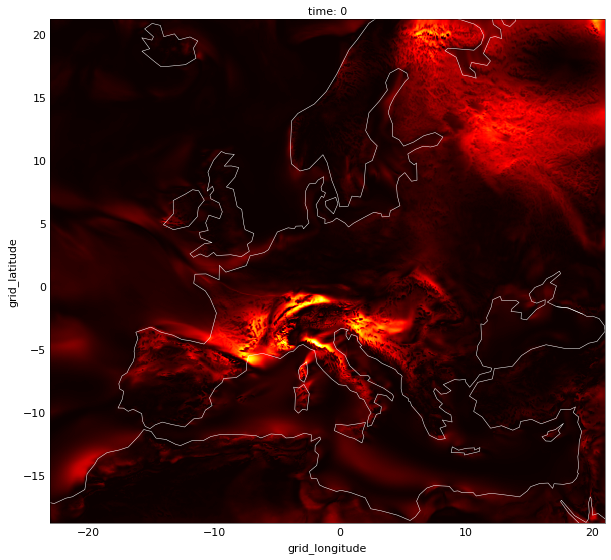

In [73]:
%%output size=275
dmap = hv.DynamicMap(slice_image_realize, kdims=[dim_time]) * cl
dmap

### Compute results

:HoloMap   [time]
   :Overlay
      .Image.I     :Image   [grid_longitude,grid_latitude]   (wind_speed)
      .Coastline.I :Feature   [Longitude,Latitude]
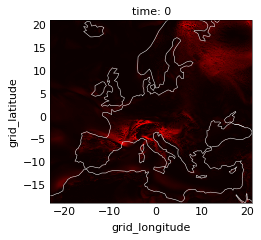
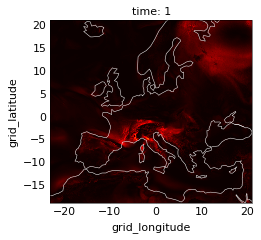
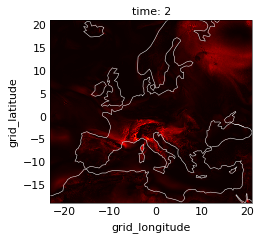
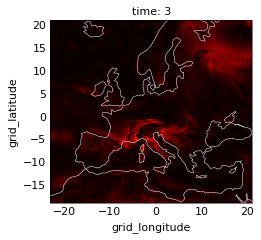
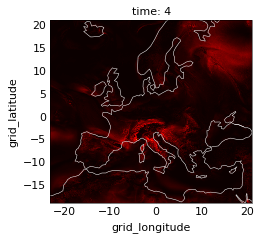
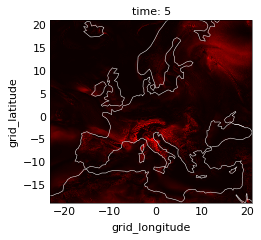
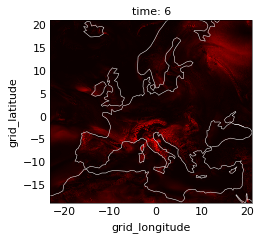
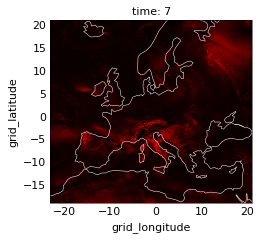
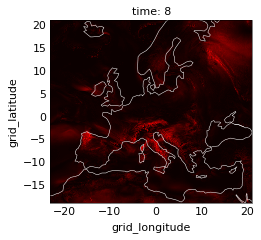
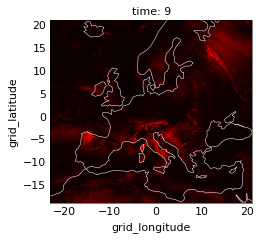
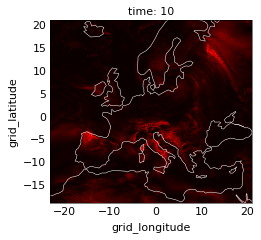
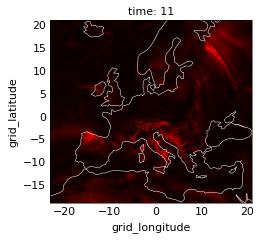
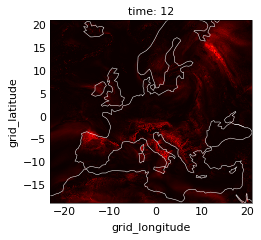
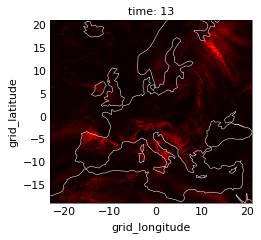
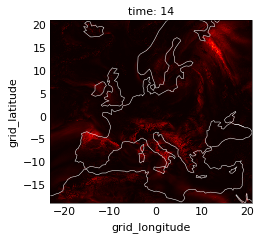
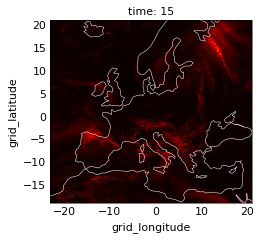
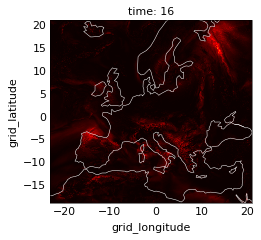
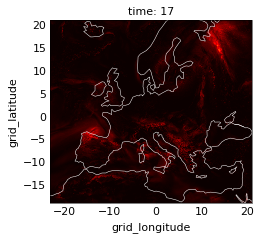
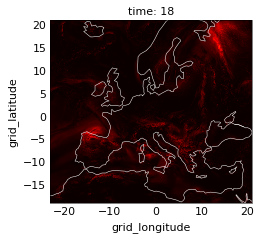
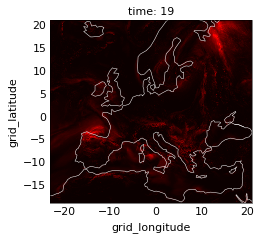
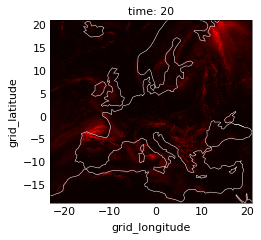
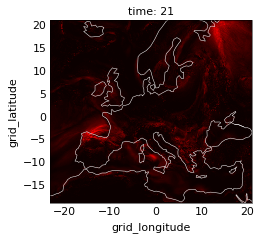
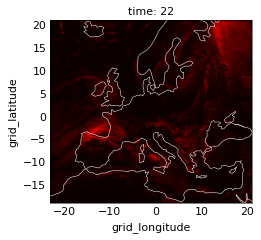
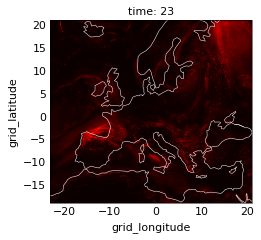
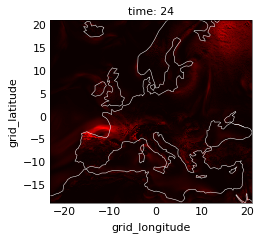
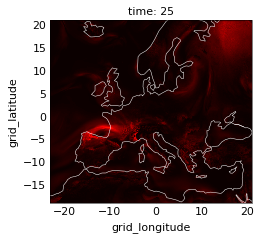
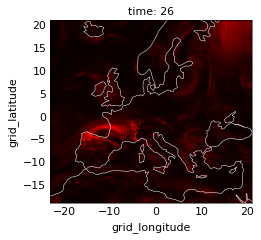
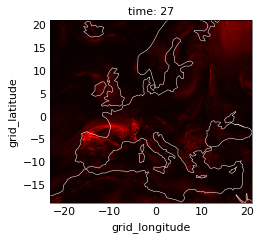
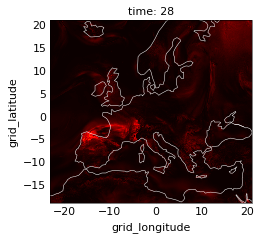
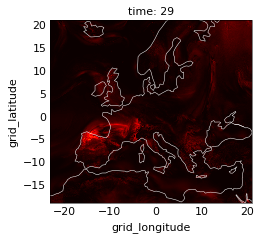
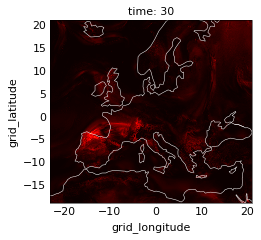
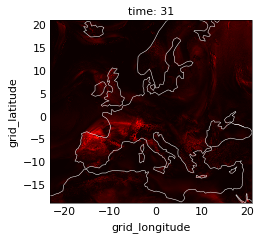
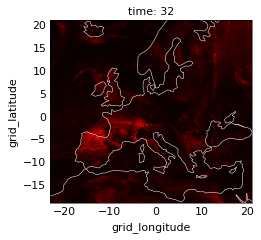
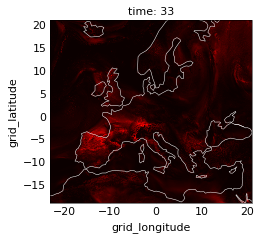
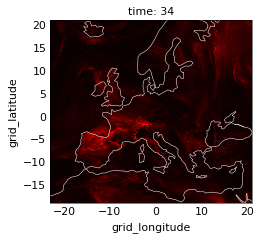
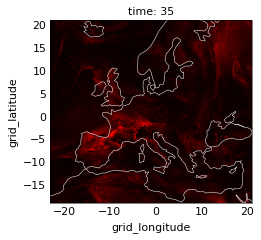
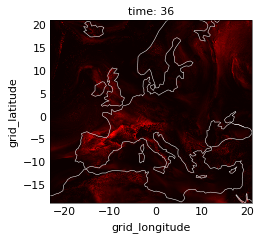
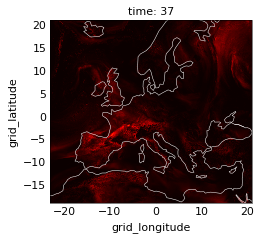
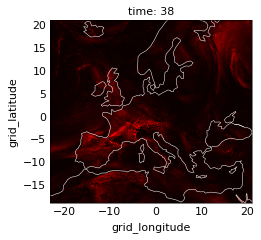
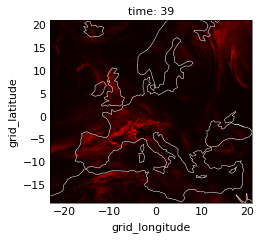
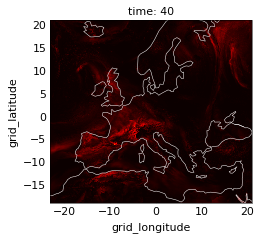
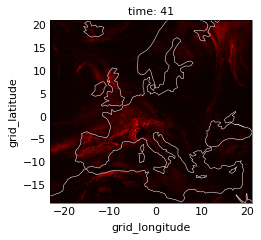
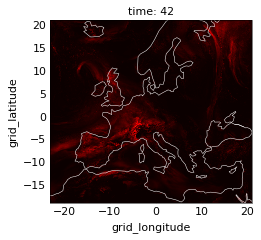
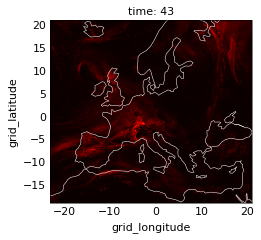
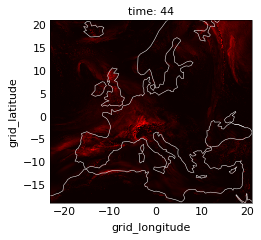
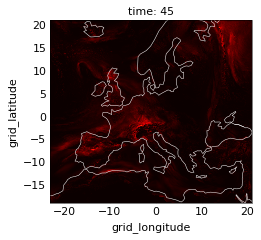
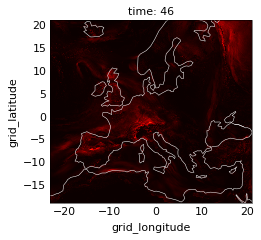
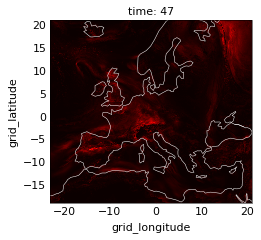
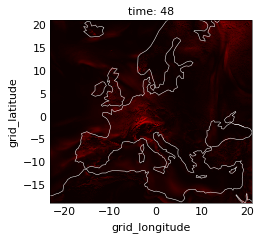
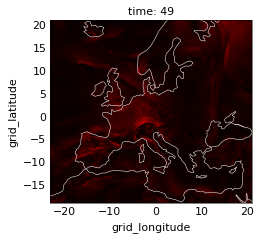
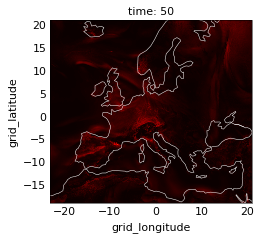
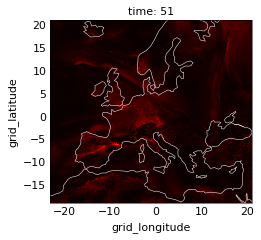
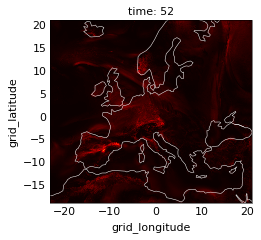
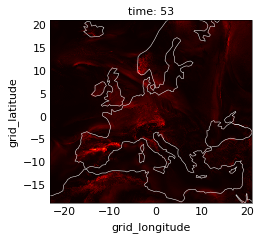
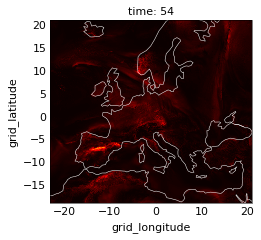
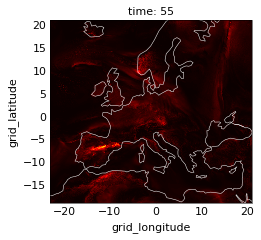
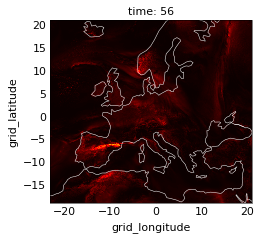
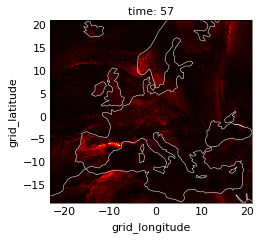
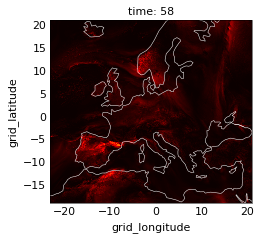
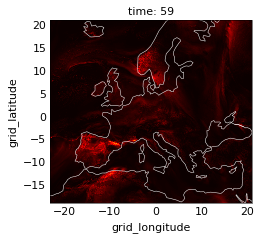
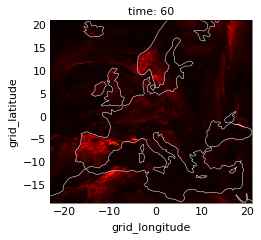
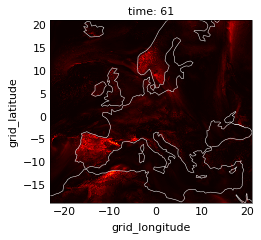
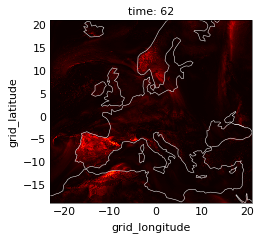
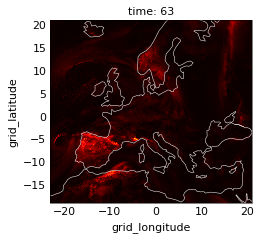
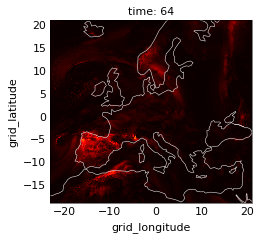
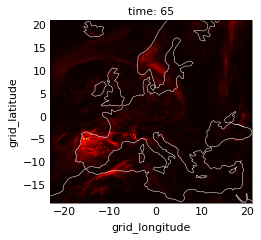
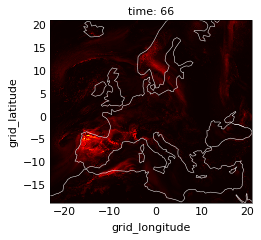
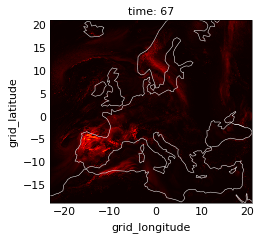
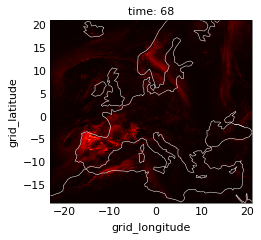
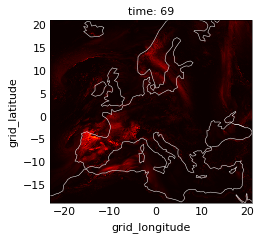
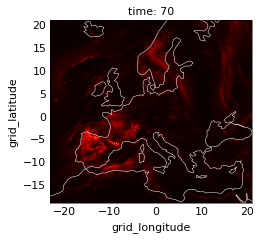
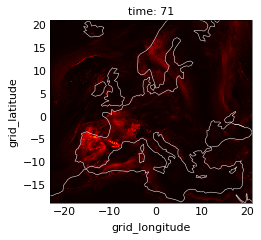
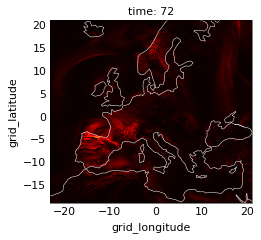
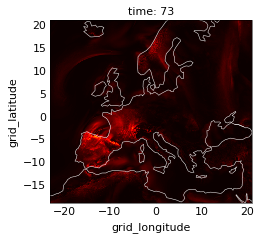
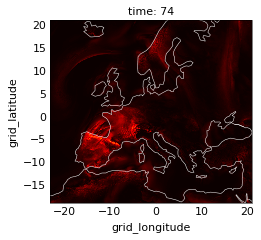
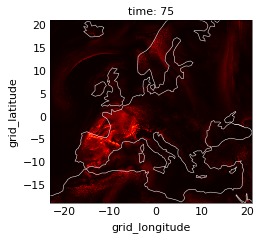
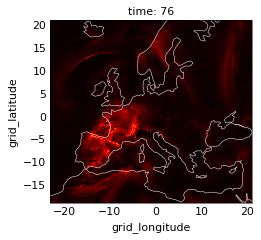
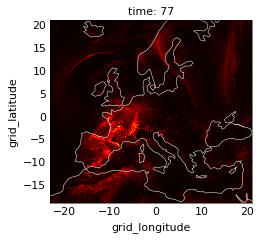
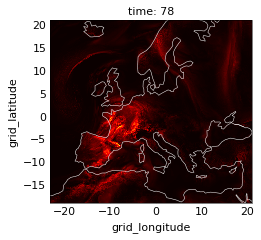
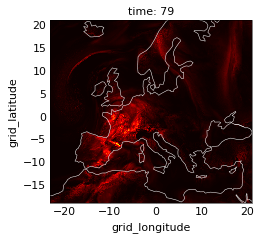
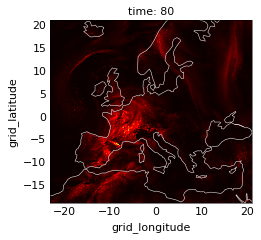
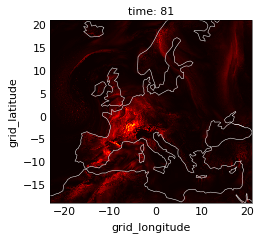
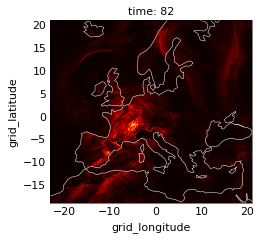
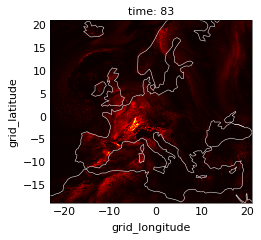
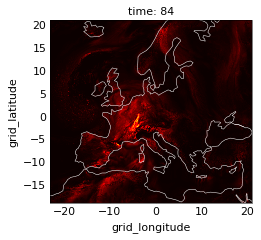
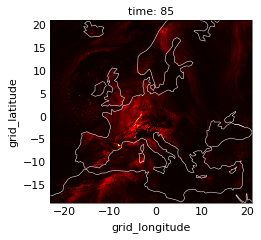
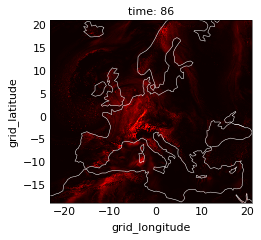
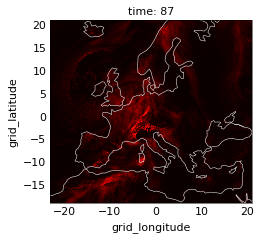
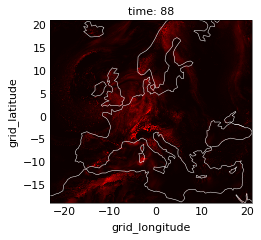
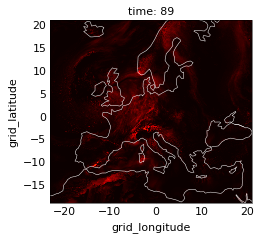
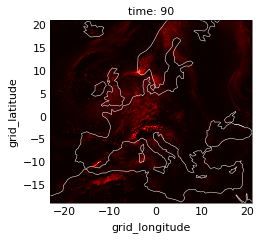
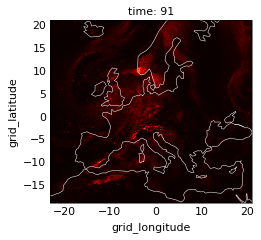
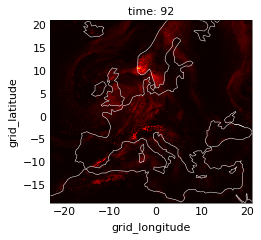
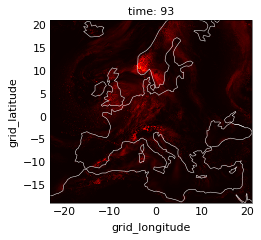
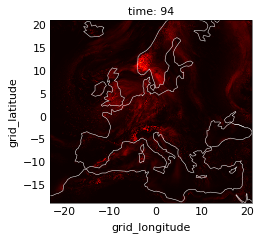
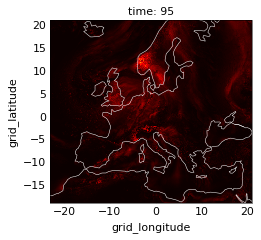
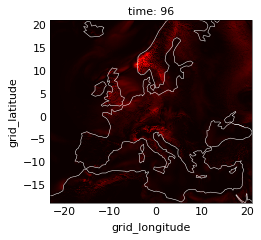
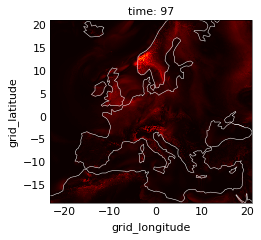
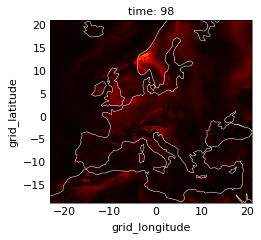
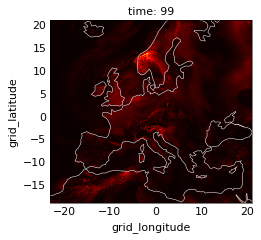

In [75]:
hv.HoloMap(dmap[set(range(100))])

In [ ]:
wspd_var_data = wspd_var_cube.data

In [23]:
wdir_var_data = wdir_var_cube.data

In [30]:
result = gv.Dataset(wspd_var_cube,
                    kdims=['time', 'grid_longitude', 'grid_latitude'], vdims=['wind_speed']
                   )
result

:Dataset   [time,grid_longitude,grid_latitude]   (wind_speed)

In [31]:
result.data

<iris 'Cube' of wind_speed / (gray) (time: 31; grid_latitude: 999; grid_longitude: 1100)>